# Deep Learning Optical Flow Estimation
## RAFT: Recurrent All-pairs Field Transforms for Optical Flow (ECCV 2020)

Zachary Teed and Jia Deng

**Original code**:

https://github.com/princeton-vl/RAFT

Torchvision implementation: https://pytorch.org/vision/main/models/raft.html

**Instructions**

Instruction figures are partially adapted from [jonassen li](https://youtu.be/r3ZtW30exoo)

**Citation**
```
@inproceedings{teed2020raft,
  title={Raft: Recurrent all-pairs field transforms for optical flow},
  author={Teed, Zachary and Deng, Jia},
  booktitle={Computer Vision--ECCV 2020: 16th European Conference, Glasgow, UK, August 23--28, 2020, Proceedings, Part II 16},
  pages={402--419},
  year={2020},
  organization={Springer}
}
```



In [ ]:
from pathlib import Path
import tempfile
from urllib.request import urlretrieve

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn import functional

from torchvision.io import read_video
import torchvision.transforms.functional as F
from torchvision.transforms import ToTensor
from torchvision.datasets import KittiFlow, Sintel
from torchvision.models.optical_flow import Raft_Large_Weights
from torchvision.utils import flow_to_image, _log_api_usage_once
from torchvision.models.optical_flow.raft import ResidualBlock, FeatureEncoder, MotionEncoder, CorrBlock, RecurrentBlock, FlowHead, UpdateBlock, MaskPredictor
from torchvision.models.optical_flow._utils import make_coords_grid, upsample_flow
from torch.nn.modules.batchnorm import BatchNorm2d
from torch.nn.modules.instancenorm import InstanceNorm2d

In [ ]:
!pip install av # 실행 후 런타임을 다시 시작하여야 반영됩니다

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.0/31.0 MB 53.3 MB/s eta 0:00:00


In [ ]:
# click this link to watch the video
video_url = "https://download.pytorch.org/tutorial/pexelscom_pavel_danilyuk_basketball_hd.mp4"

In [ ]:
video_path = Path(tempfile.mkdtemp()) / "basketball.mp4"
_ = urlretrieve(video_url, video_path)
frames, _, _ = read_video(str(video_path), output_format="TCHW")

/usr/local/lib/python3.10/dist-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


In [ ]:
# pick two pairs of images for examples
img1_batch = torch.stack([frames[100], frames[150]])
img2_batch = torch.stack([frames[101], frames[151]])

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

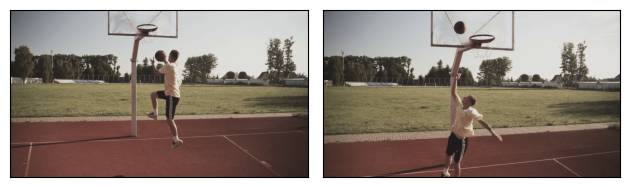

In [ ]:
# visualize the images

plt.rcParams["savefig.bbox"] = "tight"

def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

plot(img1_batch)

# 2. Sintel Dataset

In [ ]:
# transform the images
weights = Raft_Large_Weights.DEFAULT
transforms = weights.transforms()


def preprocess(img1_batch, img2_batch):
    img1_batch = F.resize(img1_batch, size=[520, 960], antialias=False)
    img2_batch = F.resize(img2_batch, size=[520, 960], antialias=False)
    return transforms(img1_batch, img2_batch)

In [ ]:
def sintel_transform(img1,img2,flow,mask):
    flow = torch.from_numpy(flow).to(device)
    trans = ToTensor()
    img1 = trans(img1)
    img1 = F.resize(img1, size=[432, 1024], antialias=False)
    img2 = trans(img2)
    img2 = F.resize(img2, size=[432, 1024], antialias=False)
    flow = F.resize(flow, size=[432, 1024], antialias=False)
    return img1, img2, flow, mask

In [ ]:
img1_batch, img2_batch = preprocess(img1_batch, img2_batch)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## MPI Sintel dataset

Synthetic dataset of 25 sequences with naturalistic effects

Dataset website: http://sintel.is.tue.mpg.de/

Example:

<img src="https://drive.google.com/uc?id=1Kre-ZAH4d5ZoisJ0pW8faXpVa97qZlmD" height = 150 width=530>

In [ ]:
# dataset
trainset = Sintel(root='/content/drive/MyDrive/AIExpert_MotionTracking_Opticalflow/dataset/',split='train',pass_name='final',transforms=sintel_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True)

# 3. Model

**Two different types of architectures**

<img src="https://drive.google.com/uc?id=1eSCQ5GKDgpxrEZfxjXIkZjb4sy8TfHQx" height = 380 width=520>

In [ ]:
# load the model weights
weights=Raft_Large_Weights.DEFAULT
weights = Raft_Large_Weights.verify(weights)

In [ ]:
class RAFT(nn.Module):
    def __init__(self, *, feature_encoder, context_encoder, corr_block, update_block, mask_predictor=None):
        super().__init__()
        _log_api_usage_once(self)

        self.feature_encoder = feature_encoder
        self.context_encoder = context_encoder
        self.corr_block = corr_block
        self.update_block = update_block

        self.mask_predictor = mask_predictor

        if not hasattr(self.update_block, "hidden_state_size"):
            raise ValueError("The update_block parameter should expose a 'hidden_state_size' attribute.")

    def forward(self, image1, image2, num_flow_updates: int = 12):

        batch_size, _, h, w = image1.shape
        if (h, w) != image2.shape[-2:]:
            raise ValueError(f"input images should have the same shape, instead got ({h}, {w}) != {image2.shape[-2:]}")
        if not (h % 8 == 0) and (w % 8 == 0):
            raise ValueError(f"input image H and W should be divisible by 8, instead got {h} (h) and {w} (w)")

        fmaps = self.feature_encoder(torch.cat([image1, image2], dim=0))
        fmap1, fmap2 = torch.chunk(fmaps, chunks=2, dim=0)
        if fmap1.shape[-2:] != (h // 8, w // 8):
            raise ValueError("The feature encoder should downsample H and W by 8")

        self.corr_block.build_pyramid(fmap1, fmap2) # 미리 계산

        context_out = self.context_encoder(image1)
        if context_out.shape[-2:] != (h // 8, w // 8):
            raise ValueError("The context encoder should downsample H and W by 8")

        hidden_state_size = self.update_block.hidden_state_size
        out_channels_context = context_out.shape[1] - hidden_state_size
        hidden_state, context = torch.split(context_out, [hidden_state_size, out_channels_context], dim=1)
        hidden_state = torch.tanh(hidden_state)
        context = functional.relu(context)

        coords0 = make_coords_grid(batch_size, h // 8, w // 8).to(fmap1.device)
        coords1 = make_coords_grid(batch_size, h // 8, w // 8).to(fmap1.device)

        flow_predictions = []
        for _ in range(num_flow_updates):
            coords1 = coords1.detach()
            corr_features = self.corr_block.index_pyramid(centroids_coords=coords1)

            flow = coords1 - coords0
            hidden_state, delta_flow = self.update_block(hidden_state, context, corr_features, flow)

            coords1 = coords1 + delta_flow

            up_mask = None if self.mask_predictor is None else self.mask_predictor(hidden_state)
            upsampled_flow = upsample_flow(flow=(coords1 - coords0), up_mask=up_mask)
            flow_predictions.append(upsampled_flow)

        return flow_predictions


## Feature Extraction

<img src="https://drive.google.com/uc?id=1OcZKNogAq016KBNHKhbTdynL3eThqJzn" height = 300 width=700>

In [ ]:
feature_encoder =FeatureEncoder(
    block=ResidualBlock, layers=(64, 64, 96, 128, 256), norm_layer=InstanceNorm2d
)
context_encoder = FeatureEncoder(
    block=ResidualBlock, layers=(64, 64, 96, 128, 256), norm_layer=BatchNorm2d
)

 ## Correlation Pyramid

  <img src="https://drive.google.com/uc?id=1WZGjgZQCfS07XESRuUXjQQTB6bT_mg7x" height = 300 width=700>
 <img src="https://drive.google.com/uc?id=1Vk3vvhuE3jJ4oUAWPzOyjN6nfrPJ-RNT" height = 300 width=700>

In [ ]:
corr_block = CorrBlock(num_levels=4, radius=4)

## Correlation Lookup

<img src="https://drive.google.com/uc?id=1fVZezNE2_SW6aYZ8NYqTa4AGViu3Pt_j" height = 200 width=500>
<br>
<img src="https://drive.google.com/uc?id=1wodOcnCjROyv0av8fIr-ZXF3BmiOajTP" height = 280 width=480>
<br>
<img src="https://drive.google.com/uc?id=1oTlCGrpeASqjsDqPRrwdSw6_Vs1HgqJ3" height = 35 width=280>
<br>
<img src="https://drive.google.com/uc?id=1PUwAHV-VzcnYgs2Blr8nTNL1oZSYhwNj" height = 50 width=380>

In [ ]:
motion_encoder = MotionEncoder(
    in_channels_corr=corr_block.out_channels,
    corr_layers=(256, 192),
    flow_layers=(128, 64),
    out_channels=128,
)

out_channels_context = 256 - 128
recurrent_block = RecurrentBlock(
    input_size=motion_encoder.out_channels + out_channels_context,
    hidden_size=128,
    kernel_size=((1,5),(5,1)),
    padding=((0,2), (2,0)),
)

## Iterative Update

<img src="https://drive.google.com/uc?id=1Wv5UF8j0Wdzr_LTd8EYfuDqJSk5AoDRn" height = 30 width=310>
<br>
<img src="https://drive.google.com/uc?id=1P-XlS5_fKWrw2i-wp6pbBMUOInqOFavI" height = 200 width=500>
<br>
<img src="https://drive.google.com/uc?id=1spB6od2gHqOld7st76nW9vPV_K4FkxHN" height = 30 width=180>

In [ ]:
flow_head = FlowHead(in_channels=128, hidden_size=256)

update_block = UpdateBlock(motion_encoder=motion_encoder, recurrent_block=recurrent_block, flow_head=flow_head)

### Convex Upsampling

<img src="https://drive.google.com/uc?id=1hjx9Nf_Xz8aRD7RQ1kta29mj9lfPxkcr" height = 350 width=450>

In [ ]:
mask_predictor = MaskPredictor(
    in_channels=128,
    hidden_size=256,
    multiplier=0.25,
)

In [ ]:
model = RAFT(
    feature_encoder=feature_encoder,
    context_encoder=context_encoder,
    corr_block=corr_block,
    update_block=update_block,
    mask_predictor=mask_predictor
)

if weights is not None:
    model.load_state_dict(weights.get_state_dict(progress=False))

model = model.to(device)

Downloading: "https://download.pytorch.org/models/raft_large_C_T_SKHT_V2-ff5fadd5.pth" to /root/.cache/torch/hub/checkpoints/raft_large_C_T_SKHT_V2-ff5fadd5.pth


# 4. Training

In [ ]:
# optimization arguments

lr=1e-9
optimizer = optim.Adam(model.parameters(),lr=lr, weight_decay=5e-4)
logging = 10
torch.manual_seed(3)

### Objective function

<img src="https://drive.google.com/uc?id=1tWxR90kG0b2_YHx_s8kl_4ViJzNYe1Gj" height = 60 width=220>

In [ ]:
def sequence_loss(flow_list, flow_gt, gamma=0.7, weights=0.1):
    n_preds = len(flow_list)
    flow_loss = 0.0
    for i in range(n_preds):
        i_weight = gamma**(n_preds - i - 1)
        i_loss = (flow_list[i] - flow_gt).abs()
        flow_loss += i_weight *  i_loss.mean()

    return weights * flow_loss

In [ ]:
# 이 셀을 실행한 이후 코드를 처음부터 다시 돌릴 일이 있을 시 런타임 재시작을 권장드립니다
model = model.train()

for batch_idx, (img1, img2, flow) in enumerate(trainloader):
    img1,img2, flow = img1.to(device),img2.to(device), flow.to(device)
    optimizer.zero_grad()
    output = model(img1,img2, num_flow_updates=12) # (B, 2, H, W). each entry corresponds to the horizontal and vertical displacement.
    loss = sequence_loss(output, flow)
    if batch_idx % logging == 0:
        print(f"iters: {batch_idx}/{len(trainloader)}, loss: {loss.item():.4f}")
    loss.backward()
    optimizer.step() # backpropagation

# 몇 분 정도 소요될 수 있습니다


iters: 0/98, loss: 0.0341
iters: 10/98, loss: 0.0437
iters: 20/98, loss: 0.0409
iters: 30/98, loss: 0.0405
iters: 40/98, loss: 0.0249
iters: 50/98, loss: 0.0239
iters: 60/98, loss: 0.0466
iters: 70/98, loss: 0.0477
iters: 80/98, loss: 0.0406
iters: 90/98, loss: 0.0446


# 5. Evaluation

In [ ]:
model = model.eval()

In [ ]:
list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")

predicted_flows = list_of_flows[-1]
print(f"dtype = {predicted_flows.dtype}")
print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")

type = <class 'list'>
length = 12 = number of iterations of the model
dtype = torch.float32
shape = torch.Size([2, 2, 520, 960]) = (N, 2, H, W)
min = -3.9007816314697266, max = 6.400392055511475


### Visualization

<img src="https://drive.google.com/uc?id=1hgtIEEqXL26AUUcJ9PcZqItQb7EGsE_X" height = 200 width=600>

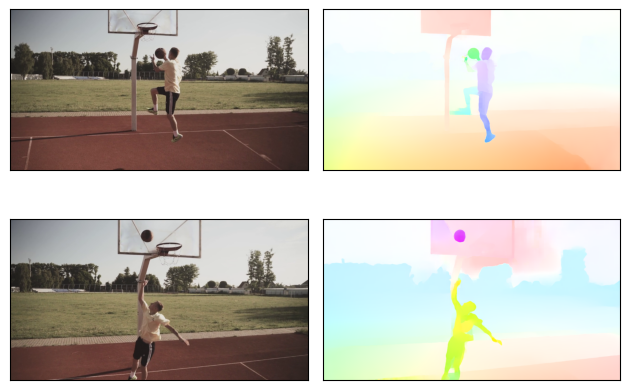

In [ ]:
# visualize the results

flow_imgs = flow_to_image(predicted_flows) # supports batches of flows

img1_batch = [(img1 + 1) / 2 for img1 in img1_batch]

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs)]
plot(grid)